In [1]:
from sklearn.pipeline import Pipeline
import pandas as pd 
import numpy as np
import os
import sys
sys.path.append('../src')

# Source code
from transforms import *
import experiment

# Global variables
MODELS_FOLDER = os.path.join('..', 'models')
PIPELINE_NAME = 'pipeline.pkl'
DATA_FOLDER = os.path.join('..', 'data')
DATA_FOLDER_RAW = os.path.join(DATA_FOLDER, 'raw')
DATA_NAME_RAW = 'winequality_90.csv'
SEED = 93849823
ACTION = 'load' # set "load" to just load the results or "train" to train them all again

# Warnings off:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Set the random state seed for reproducibility
np.random.seed(SEED)

import joblib

# Load dataset


In [2]:
data = pd.read_csv(os.path.join(DATA_FOLDER_RAW, DATA_NAME_RAW))
data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,Red,8.2,0.635,0.10,2.1,0.073,25.0,60.0,0.99638,3.29,0.75,10.9,6
1,White,5.7,0.100,0.27,1.3,0.047,21.0,100.0,0.99280,3.27,0.46,9.5,5
2,White,6.9,0.280,0.24,2.1,0.034,49.0,121.0,0.98882,2.98,0.43,13.2,7
3,White,5.8,0.360,0.38,0.9,0.037,3.0,75.0,0.99040,3.28,0.34,11.4,4
4,White,7.4,0.200,0.36,1.2,0.038,44.0,111.0,0.99260,3.36,0.34,9.9,6


We can build the pipeplinr from scratch by using the classes under the `transforms.py`. However, we already did that and we encourage you to use the `pipeline.pkl`, which has been built using `sklearn` structured and pipeline class.

In [3]:
pipeline = joblib.load(os.path.join(MODELS_FOLDER, PIPELINE_NAME))
pipeline.steps

[('cleaner', <transforms.DataCleaning at 0x7f823d1c4eb8>),
 ('remover', <transforms.RemoveFeatures at 0x7f823d1c4cf8>),
 ('scaler', <transforms.FeatureScaling at 0x7f823d1c4da0>),
 ('droper', <transforms.DropNaN at 0x7f823d1183c8>)]

This is how to use the pipeline

In [4]:
labels = GetLables().fit_transform(data)
labels

array([3, 2, 4, ..., 4, 3, 3])

In [5]:
features = data.drop('quality', axis=1)
features.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,Red,8.2,0.635,0.10,2.1,0.073,25.0,60.0,0.99638,3.29,0.75,10.9
1,White,5.7,0.100,0.27,1.3,0.047,21.0,100.0,0.99280,3.27,0.46,9.5
2,White,6.9,0.280,0.24,2.1,0.034,49.0,121.0,0.98882,2.98,0.43,13.2
3,White,5.8,0.360,0.38,0.9,0.037,3.0,75.0,0.99040,3.28,0.34,11.4
4,White,7.4,0.200,0.36,1.2,0.038,44.0,111.0,0.99260,3.36,0.34,9.9


In [6]:
features_transformed = pipeline.fit_transform(features)
features_transformed.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.753317,1.794928,-1.511482,-0.701777,0.474572,-0.311825,-0.986257,-0.092347,0.440301,1.454997,0.347380
1,-1.168491,-1.453357,-0.336296,-0.869575,-0.258709,-0.536331,-0.279840,-0.092822,0.315747,-0.474754,-0.831347
2,-0.246023,-0.360476,-0.543682,-0.701777,-0.625349,1.035214,0.091029,-0.093351,-1.490295,-0.674383,2.283859
3,-1.091618,0.125249,0.424119,-0.953474,-0.540740,-1.546611,-0.721351,-0.093141,0.378024,-1.273271,0.768353
4,0.138338,-0.846201,0.285862,-0.890550,-0.512537,0.754581,-0.085575,-0.092849,0.876242,-1.273271,-0.494568


In [7]:
features_transformed.index.values

array([   0,    1,    2, ..., 5844, 5845, 5846])

In [8]:
labels = labels[features_transformed.index.values]
labels.shape

(5813,)

In [9]:
df_labels = pd.DataFrame(labels, columns=['labels'])

In [10]:
df_labels.groupby('labels').labels.value_counts()

labels  labels
0       0           27
1       1          194
2       2         1918
3       3         2533
4       4          962
5       5          174
6       6            5
Name: labels, dtype: int64

We have a problem: the classe 6, which is the quality #9 has only 5 sample. We proposed to this one sample 5, which is quality #8

In [11]:
labels[labels == 6] = 5

In [12]:
df_labels = pd.DataFrame(labels, columns=['labels'])
df_labels.groupby('labels').labels.value_counts()

labels  labels
0       0           27
1       1          194
2       2         1918
3       3         2533
4       4          962
5       5          179
Name: labels, dtype: int64

Now we are all set!

# Experiment 01:
- All classifiers


In [13]:
def do_experiment(results_name, folder, features, labels, n_classes=6, action='load', classifiers={}, kfold=5):
    print(action)
    if action=='train':
        print(folder)
        # Train all clf
        ### Stratified cross-validation for model selection will be used.

        clf_outputs = experiment.run_classifiers(features, labels, classifiers, kfolds)

        ## Performance assessment
        results = {}
        results['train'] = experiment.results_clf(n_classes, clf_outputs['train']['true'], clf_outputs['train']['pred'])
        results['test'] = experiment.results_clf(n_classes, clf_outputs['test']['true'], clf_outputs['test']['pred'])

        ## Save results
        print(folder)
        experiment.export_results(results['test'], 'test', foldertree=folder)
        experiment.export_results(results['train'], 'train', foldertree=folder)

        name = os.path.join(folder, results_name)
        joblib.dump(results, name)
        
        return results
    
    elif action == 'load':
        name = os.path.join(folder, results_name)
        return joblib.load('{}'.format(name))

In [14]:
# Definitions
results_obj_name = 'results-01-clf-all.pkl'
results_folder = os.path.join('Results-analyses-3', '01-all-clf')
kfolds = 10
n_classes = np.unique(labels).shape[0]

# Define all classifiers:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.ensemble import VotingClassifier

# No hyperparameter tunning for now. They default setting will be used.

knn_clf = KNeighborsClassifier()
random_forest_clf = RandomForestClassifier()
naive_bayes_clf = GaussianNB()
gaussian_linear_clf = LinearDiscriminantAnalysis()
gaussian_quadratic_clf = QuadraticDiscriminantAnalysis()
perceptron_clf = Perceptron()
sgd_clf = SGDClassifier()

# MLP:
mlp_clf = MLPClassifier(solver='adam', learning_rate='adaptive', 
                        max_iter=1300, learning_rate_init=5e-04, tol=1e-4)

mlp_clf_2 = MLPClassifier(solver='lbfgs', learning_rate='adaptive', 
                        max_iter=1300, learning_rate_init=5e-04, tol=1e-4)

eclf = VotingClassifier(estimators=[('mlp', mlp_clf), ('mlp-2', mlp_clf_2), ('naive-bayes', naive_bayes_clf)], 
                        voting='soft', weights=[0.75, 0.75, 1.4])

# Place them all in a dict

classifiers = {'KNN': knn_clf, 'RF': random_forest_clf, 'Naive_bayes': naive_bayes_clf,
               'Gaussian_linear': gaussian_linear_clf, 'Gaussian_quadratic': gaussian_quadratic_clf,
               'Perceptron': perceptron_clf, 'SGDClassifier': sgd_clf,
               'MLP': mlp_clf,
               'Ensemble': eclf}

In [15]:
results_exp_01 = do_experiment(results_obj_name, results_folder, features=features_transformed.values, labels=labels.ravel(), 
                               classifiers=classifiers, action='load', n_classes=n_classes, kfold=10)

load


## The results from this part:

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
def see_results(results):
    result_df = pd.DataFrame(columns=['acc', 'recall', 'precision'], index=results['test'].keys())
    
    for clf in results['test'].keys():
        result_df.loc[clf]['acc'] = results['test'][clf]['average']['acc']
        result_df.loc[clf]['recall'] = results['test'][clf]['average']['recall']
        result_df.loc[clf]['precision'] = results['test'][clf]['average']['precision']
    
    return result_df

In [18]:
result_df_clf_all = see_results(results_exp_01)
result_df_clf_all

,acc,recall,precision
KNN,0.557033,0.557033,0.544945
RF,0.666574,0.666574,0.662945
Naive_bayes,0.139001,0.139001,0.428307
Gaussian_linear,0.53604,0.53604,0.500527
Gaussian_quadratic,0.162248,0.162248,0.458032
Perceptron,0.411208,0.411208,0.390083
SGDClassifier,0.45161,0.45161,0.429569
MLP,0.570258,0.570258,0.557542
Ensemble,0.478327,0.478327,0.571332


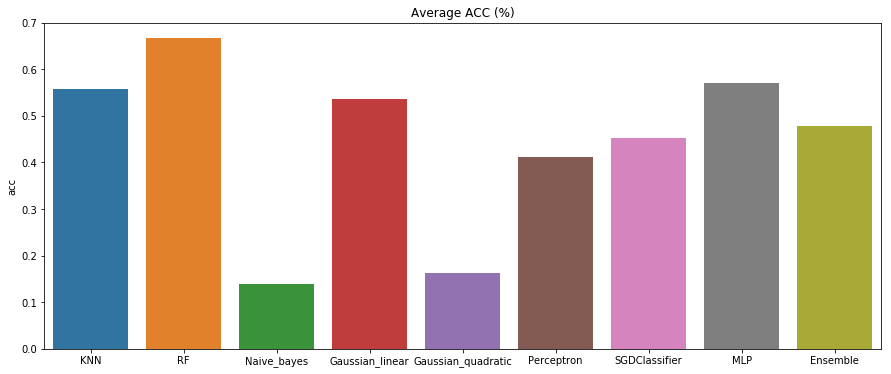

In [19]:
ax, fig = plt.subplots(figsize=(15,6))
sns.barplot(y='acc', x=result_df_clf_all.index, data=result_df_clf_all)
# plt.ylim(0.967, 0.99)
plt.title('Average ACC (%)')
plt.show()

The accuracy metric is not a good fit for this type of proble, since the classes are unbalanced. Let's go over other metrics

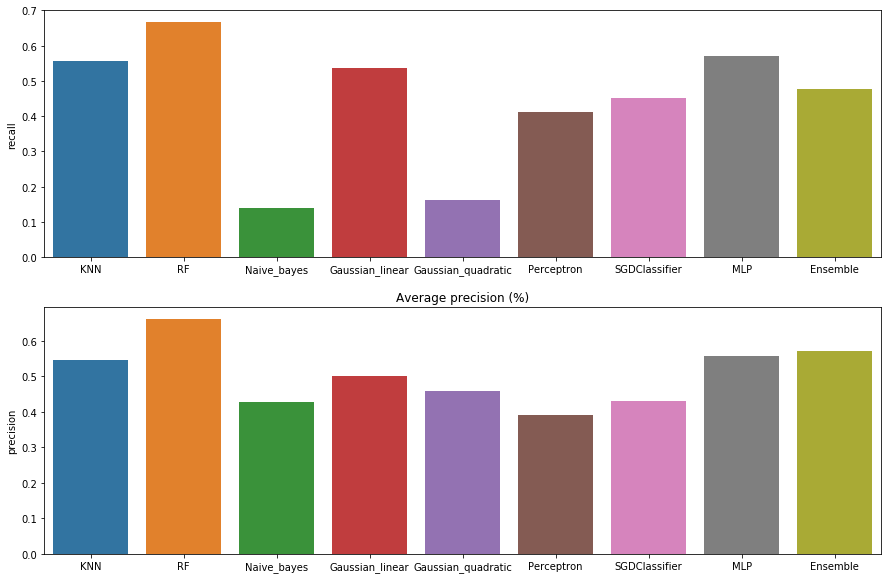

In [20]:
fig, axes = plt.subplots(2,1,figsize=(15,10))
sns.barplot(y='recall', x=result_df_clf_all.index, data=result_df_clf_all, ax = axes[0])
plt.title('Average Recall (%)')

sns.barplot(y='precision', x=result_df_clf_all.index, data=result_df_clf_all, ax = axes[1])
plt.title('Average precision (%)')

plt.show()

Setting the baseline to 0.967 we can exclude all model in which reached accuracies below. Therefore, only the Random Forest (RF) and MLP performed properly. Having the R outperforming in about 1% in average.

# Experiment 02 - Test another models:
- Bagged classifiers with AdaBoost algorithm;
- No feature selection employed;

In [21]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Definitions
results_obj_name = 'results-02-clf-adaboost.pkl'
results_folder = os.path.join('Results-analyses-3', '02-Adaboost')
kfolds = 10
n_classes = np.unique(labels).shape[0]

# CLF definitions
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)

bnn = AdaBoostClassifier(SGDClassifier(),
                         algorithm="SAMME",
                         n_estimators=50)

classifiers_adabost = {'BDT': bdt, 'BNN': bnn}

In [22]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5])

In [23]:
results_exp_02 = do_experiment(results_obj_name, results_folder, features=features_transformed.values, labels=labels.ravel(), 
                               classifiers=classifiers_adabost, n_classes=n_classes, action='load')

load


In [24]:
result_df_bagged = see_results(results_exp_02)
result_df_bagged

,acc,recall,precision
BDT,0.50782,0.50782,0.470173
BNN,0.449344,0.449344,0.445621


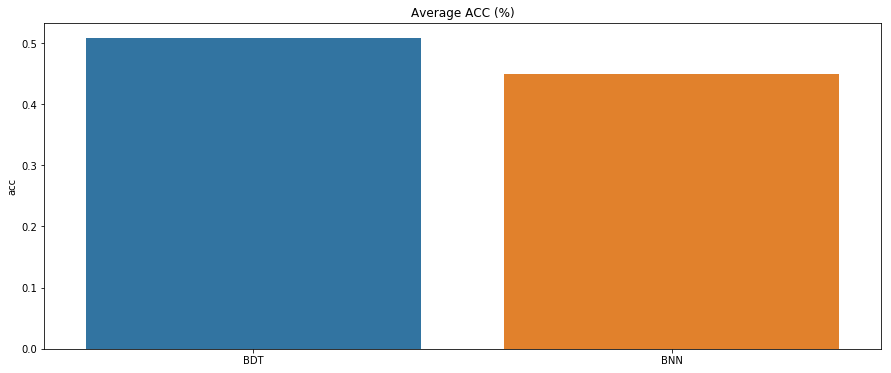

In [25]:
ax, fig = plt.subplots(figsize=(15,6))
sns.barplot(y='acc', x=result_df_bagged.index, data=result_df_bagged)
plt.title('Average ACC (%)')
plt.show()

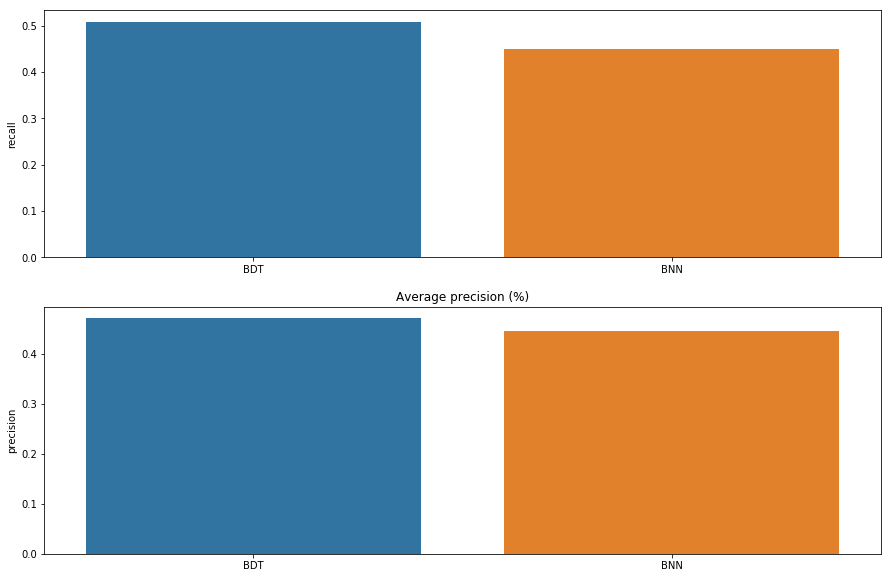

In [26]:
fig, axes = plt.subplots(2,1,figsize=(15,10))
sns.barplot(y='recall', x=result_df_bagged.index, data=result_df_bagged, ax = axes[0])
plt.title('Average Recall (%)')

sns.barplot(y='precision', x=result_df_bagged.index, data=result_df_bagged, ax = axes[1])
plt.title('Average precision (%)')

plt.show()

The bagged of decisions tree performed almost as the RF, so there wont be necessary to use them from now. The bagged of Perceptrons will not be used.

# Experiment 03:
- The "best" classifiers up until now (RF and  MLP)
- Feature selection of the most important features: `volatile acidity`, `alcohol` and `chlorides`

In [27]:
from sklearn.pipeline import Pipeline

pipeline_selector = Pipeline([('cleaner', DataCleaning()),
                     ('selector', FeatureSelection(features=['volatile acidity', 'alcohol', 'chlorides'])),
                     ('scaler', FeatureScaling()),
                     ('droper', DropNaN())])

In [28]:
features_transformed_02 = pipeline_selector.fit_transform(features)
features_transformed_02.head()

,volatile acidity,alcohol,chlorides
0,1.794928,0.347380,0.474572
1,-1.453357,-0.831347,-0.258709
2,-0.360476,2.283859,-0.625349
3,0.125249,0.768353,-0.540740
4,-0.846201,-0.494568,-0.512537


In [29]:
labels = GetLables().fit_transform(data)
labels

array([3, 2, 4, ..., 4, 3, 3])

In [30]:
labels = labels[features_transformed_02.index.values]
labels.shape

(5813,)

In [31]:
labels[labels == 6] = 5

Only 3 features:

In [32]:
# Definitions
results_obj_name = 'results-03-clf-feat_selected.pkl'
results_folder = os.path.join('Results-analyses-3', '03-Feature-selected')
kfolds = 10
n_classes = np.unique(labels).shape[0]

# CLF definitions as  the same above in the Expr 01
classifiers_feat_selected = {'MLP': mlp_clf, 'RF': random_forest_clf}

In [33]:
results_exp_03 = do_experiment(results_obj_name, results_folder, features=features_transformed_02.values, labels=labels.ravel(), 
                               classifiers=classifiers_feat_selected, n_classes=n_classes, action='load')

load


In [34]:
result_df_feat_selected = see_results(results_exp_03)
result_df_feat_selected

,acc,recall,precision
MLP,0.543096,0.543096,0.516676
RF,0.609643,0.609643,0.59897


In [35]:
results_comparison = pd.DataFrame([result_df_clf_all.loc['RF']['acc'], result_df_feat_selected.loc['RF']['acc']],
                                    index=['11 features', '3 features'], columns=['RF'])

results_comparison['MLP'] = [result_df_clf_all.loc['MLP']['acc'], result_df_feat_selected.loc['MLP']['acc']]
results_comparison

,RF,MLP
11 features,0.666574,0.570258
3 features,0.609643,0.543096


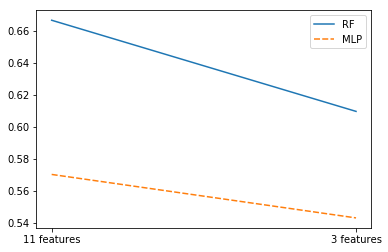

In [36]:
sns.lineplot(data=results_comparison)

Removing these features does not to seem very good.

In [37]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=20):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

Text(0.5, 1.0, 'MLP confusion matrix')

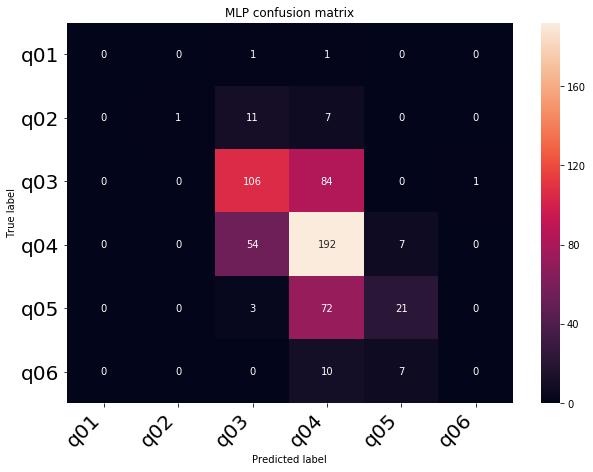

In [38]:
fig = print_confusion_matrix(results_exp_03['test']['MLP']['confMat'][9], class_names=np.array(['q01', 'q02', 'q03', 'q04', 'q05', 'q06']))
plt.title('MLP confusion matrix')

Text(0.5, 1.0, 'RF confusion matrix')

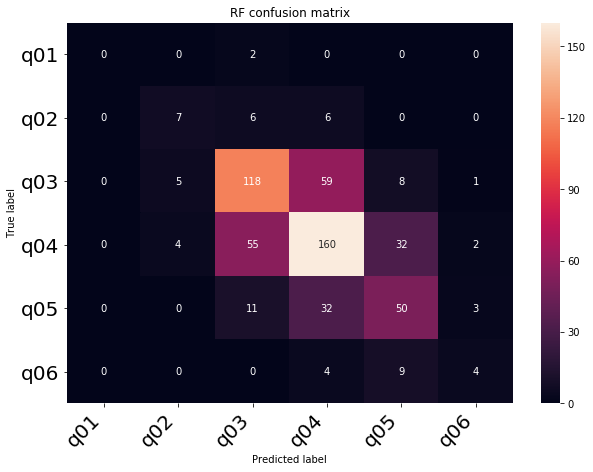

In [39]:
fig = print_confusion_matrix(results_exp_03['test']['RF']['confMat'][9], class_names=np.array(['q01', 'q02', 'q03', 'q04', 'q05', 'q06']))
plt.title('RF confusion matrix')

Interisting!! Most of the mistakes are from the low and higher qualities. Let's try something different: turn this problem into binary by grouping qualities below 6 as **bad** abore as **good** 

# Experiment 04:
- Binary;

In [40]:
labels[labels <= 2] = 0
labels[labels > 2] = 1

In [41]:
np.unique(labels)

array([0, 1])

In [42]:
# Definitions
results_obj_name = 'results-03-clf-binary.pkl'
results_folder = os.path.join('Results-analyses-3', '04-Binary')
kfolds = 10
n_classes = np.unique(labels).shape[0]

# CLF definitions as  the same above in the Expr 01
classifiers_feat_selected = {'MLP': mlp_clf, 'RF': random_forest_clf}

In [43]:
results_exp_04 = do_experiment(results_obj_name, results_folder, features=features_transformed.values, labels=labels.ravel(), 
                               classifiers=classifiers_feat_selected, n_classes=n_classes, action='load')

load


In [44]:
result_df_binary = see_results(results_exp_04)
result_df_binary

,acc,recall,precision
MLP,0.780144,0.780144,0.777903
RF,0.810424,0.810424,0.8107


Text(0.5, 1.0, 'RF confusion matrix')

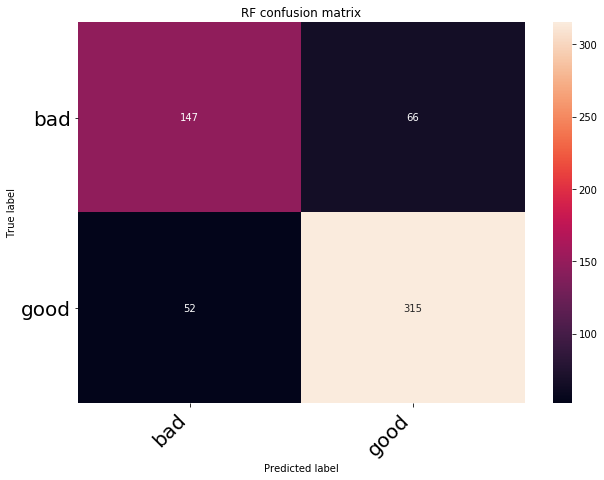

In [45]:
fig = print_confusion_matrix(results_exp_04['test']['RF']['confMat'][9], class_names=np.array(['bad', 'good']))
plt.title('RF confusion matrix')

# Hyperparameter tunning

In [46]:
# MLP:
mlp_clf = MLPClassifier(solver='adam', learning_rate='adaptive', max_iter=1300, learning_rate_init=5e-04, tol=1e-4)

In [47]:
random_forest_clf = RandomForestClassifier()

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'RF': 
                   {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap},
               'MLP':
                   {"hidden_layer_sizes": list(np.arange(2,1001))}
              }

classifiers = {'RF': random_forest_clf, 'MLP': mlp_clf}

In [48]:
from sklearn.model_selection import RandomizedSearchCV

random_search = dict((k,[]) for k in classifiers.keys())

In [49]:
features_transformed = pipeline.fit_transform(features)
features_transformed.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.753317,1.794928,-1.511482,-0.701777,0.474572,-0.311825,-0.986257,-0.092347,0.440301,1.454997,0.347380
1,-1.168491,-1.453357,-0.336296,-0.869575,-0.258709,-0.536331,-0.279840,-0.092822,0.315747,-0.474754,-0.831347
2,-0.246023,-0.360476,-0.543682,-0.701777,-0.625349,1.035214,0.091029,-0.093351,-1.490295,-0.674383,2.283859
3,-1.091618,0.125249,0.424119,-0.953474,-0.540740,-1.546611,-0.721351,-0.093141,0.378024,-1.273271,0.768353
4,0.138338,-0.846201,0.285862,-0.890550,-0.512537,0.754581,-0.085575,-0.092849,0.876242,-1.273271,-0.494568


In [50]:
features_transformed.shape

(5813, 11)

In [51]:
labels = GetLables().fit_transform(data)
labels

array([3, 2, 4, ..., 4, 3, 3])

In [52]:
labels.shape

(5847,)

In [53]:
labels = labels[features_transformed.index.values]
labels.shape

(5813,)

In [54]:
results_obj_name = 'results-04-mlp-random-search.pkl'
results_folder = os.path.join('Results-analyses-3', '05-Hyperparameter_tuning')

action = 'load'

if action == 'train':
    for clf in random_grid.keys():
        random_search[clf] = RandomizedSearchCV(classifiers[clf], random_grid[clf], cv=10, n_iter=20, verbose=5, scoring='accuracy')
        random_search[clf].fit(features_transformed.values, y=labels.ravel())
        joblib.dump(random_search, os.path.join(results_folder, results_obj_name))
else:
    random_search = joblib.load(os.path.join(results_folder, results_obj_name))

In [55]:
random_search['RF'].best_score_

0.689661104421125

# Train the random forest in the chunk of 90% of the dataset.

In [56]:
labels = GetLables().fit_transform(data)
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6])

In [57]:
labels[labels <= 2] = 0
labels[labels > 2] = 1
np.unique(labels)

array([0, 1])

In [58]:
X = features_transformed.values
y = labels[features_transformed.index]

In [59]:
random_forest_clf = random_search['RF'].best_estimator_
random_forest_clf.set_params(random_state=SEED)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=40, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=93849823, verbose=0,
            warm_start=False)

In [60]:
random_forest_clf.fit(X, y)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=40, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=93849823, verbose=0,
            warm_start=False)

Save the pipeline

In [76]:
pipeline.steps

[('cleaner', <transforms.DataCleaning at 0x7f823d1c4eb8>),
 ('remover', <transforms.RemoveFeatures at 0x7f823d1c4cf8>),
 ('scaler', <transforms.FeatureScaling at 0x7f823d1c4da0>),
 ('droper', <transforms.DropNaN at 0x7f823d1183c8>)]

In [83]:
joblib.dump(pipeline, os.path.join(MODELS_FOLDER, 'pipeline.pkl'))

['../models/pipeline.pkl']

# Test the model over the chunk of 10%

In [ ]:
data_10 = pd.read_csv(os.path.join(DATA_FOLDER_RAW, 'winequality_10.csv'))
data_10.head()

In [ ]:
labels_10 = GetLables().fit_transform(data_10)
labels_10[labels_10 <= 2] = 0
labels_10[labels_10 > 2] = 1
np.unique(labels)

In [ ]:
features_10 = data_10.drop('quality', axis=1)
features_10.head()

In [ ]:
features_10_transformed = pipeline.transform(features_10)
features_10_transformed.head()

In [ ]:
y_hat = random_forest_clf.predict(features_10_transformed)
y_hat.shape

In [ ]:
y_10 = labels_10[features_10_transformed.index]
y_10.shape

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [ ]:
print(classification_report(y_10, y_hat))

In [ ]:
print(accuracy_score(y_10, y_hat))

In [ ]:
print(confusion_matrix(y_10, y_hat))

Percentage confusion matrix

In [ ]:
print(experiment.percentage_confMat(confusion_matrix(y_10, y_hat)))

### Save the model

In [ ]:
joblib.dump(random_forest_clf, os.path.join(MODELS_FOLDER, 'random_forest_1000est_2leaf_depth40.pkl'))

In [ ]:
features.loc[0].to_json('aeae.json')